In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from catboost import Pool, cv
from catboost import CatBoost, Pool, MetricVisualizer
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
import shap
from copy import deepcopy

In [2]:
df = pd.read_csv(r'C:\Users\volgi\VK\first_route\intern_task.csv')

In [3]:
df.sample(5)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
156311,1,19330,2.0,2.0,2.0,2.0,2.0,1.000000,1.0,1.0,...,0.0,0.0,0.222222,1.000000,15.714401,1.0,0.042644,0.000000,32.0,16.000000
93709,0,12220,4.0,0.0,2.0,0.0,4.0,1.000000,0.0,0.5,...,1.0,1.8,0.000000,0.821734,11.472726,0.0,0.028302,0.000244,10.0,2.500000
141182,0,17725,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
183025,0,22240,1.0,0.0,0.0,0.0,1.0,0.333333,0.0,0.0,...,0.0,0.0,0.000000,0.621284,0.000000,0.0,0.002899,0.000018,1.0,0.333333
185177,0,22450,1.0,0.0,1.0,0.0,1.0,1.000000,0.0,1.0,...,6.0,18.2,0.000000,1.000000,13.930938,0.0,0.049605,0.000000,42.0,42.000000


In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [5]:
df.isna().sum()

rank           0
query_id       0
feature_0      0
feature_1      0
feature_2      0
              ..
feature_139    0
feature_140    0
feature_141    0
feature_142    0
feature_143    0
Length: 146, dtype: int64

In [6]:
df.isna().sum().sum()

0

In [7]:
df.nunique()

rank               5
query_id        2000
feature_0         16
feature_1         10
feature_2         15
               ...  
feature_139       29
feature_140    41864
feature_141     4703
feature_142      529
feature_143     1431
Length: 146, dtype: int64

In [8]:
cols2drop = []
for i in df.columns:
    if df[i].nunique() == 1:
        cols2drop.append(i)

In [9]:
cols2drop

['feature_64', 'feature_65', 'feature_72', 'feature_100']

In [10]:
df.drop(cols2drop, axis=1, inplace=True)

In [11]:
cutoff_id = df["query_id"].quantile(0.9)
X_train = df.loc[df.query_id< cutoff_id].drop(["rank"],axis=1)
X_eval = df.loc[df.query_id>= cutoff_id].drop(["rank"],axis=1)
y_train = df.loc[df.query_id< cutoff_id]["rank"]
y_eval = df.loc[df.query_id>= cutoff_id]["rank"]

In [12]:
train_pool = Pool(data=X_train,
                  label = y_train,
                  group_id=X_train["query_id"]
                 )

eval_pool = Pool(data=X_eval,
                  label = y_eval,
                  group_id=X_eval["query_id"]
                 )

In [13]:
 default_parameters  = {
    'iterations': 2000,
    'custom_metric': ['NDCG', "AUC:type=Ranking"],
    'verbose': False,
    'random_seed': 42,
    "has_time":True,
    "metric_period":4,
    "save_snapshot":False,
    "use_best_model":True,
} 

In [14]:
def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=eval_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    print("(Default) Feature importance (on train pool)")
    display(model.get_feature_importance(data=train_pool,prettified=True).head(15))
    
    try:
        print("SHAP features importance, on all data:")
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(pd.concat([X_train,X_eval]),
                                            y=pd.concat([y_train,y_eval]))

        shap.summary_plot(shap_values, pd.concat([X_train,X_eval]))
    finally:
        return model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

(Default) Feature importance (on train pool)


,Feature Id,Importances
0,feature_133,0.004465
1,feature_13,0.002829
2,feature_107,0.002388
3,feature_132,0.002033
4,feature_129,0.001858
5,feature_128,0.001852
6,feature_127,0.001416
7,feature_130,0.001204
8,feature_125,0.001117
9,feature_131,0.001089


SHAP features importance, on all data:


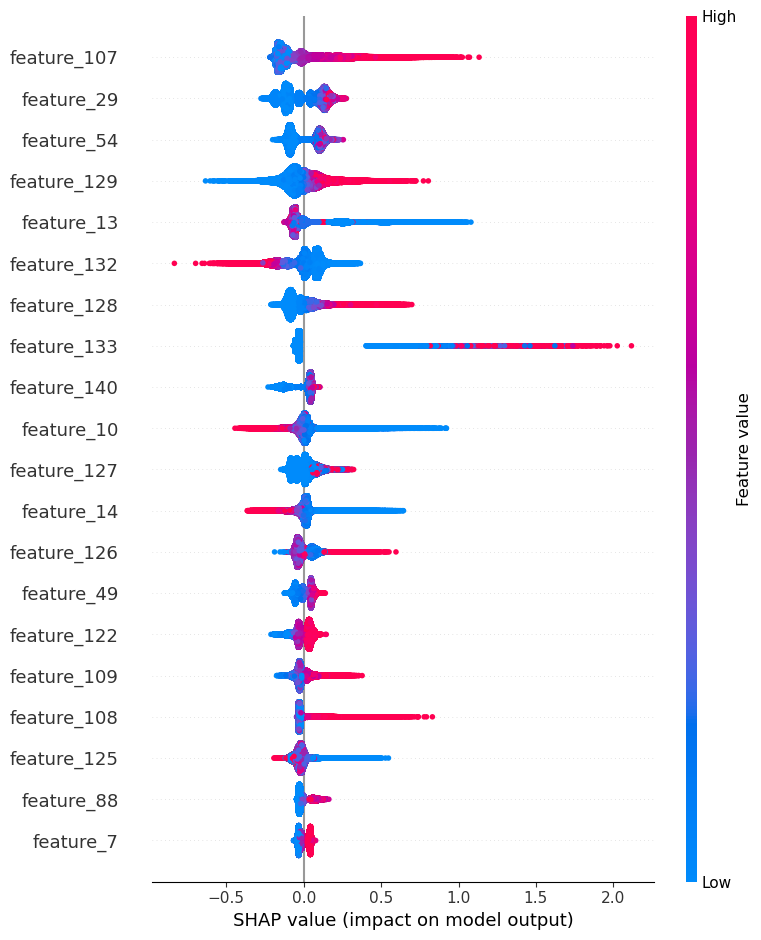

In [15]:
model = fit_model('YetiRank')